In [1]:
from src import GMM, BIC_GMM
from src import generate_multimodal_data, generate_means_stds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
from typing import Type

# GMM visualization

## Simple gaussians

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_81832/234265166.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


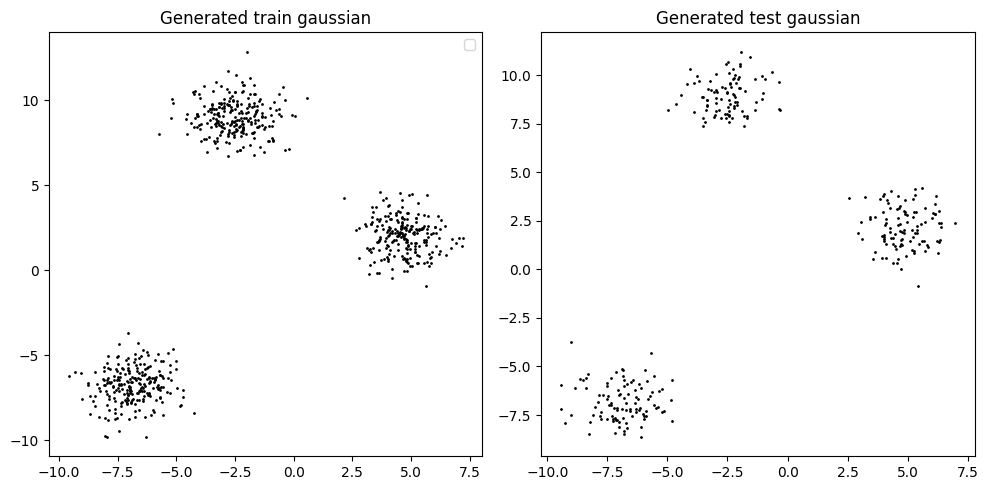

In [2]:
# Generate a multimodal dataset
OMP_NUM_THREADS=1
X, y = generate_multimodal_data(n_samples=1000, n_features=2, n_classes=1, n_clusters_per_class=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Generated train gaussian")
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Generated test gaussian")
plt.scatter(X_test[:, 0], X_test[:, 1], s=1, c="black")

plt.tight_layout()
plt.show()

In [3]:
gmm_classifier = GMM(n_components=3, tol=0)
gmm_classifier.fit(X_train)

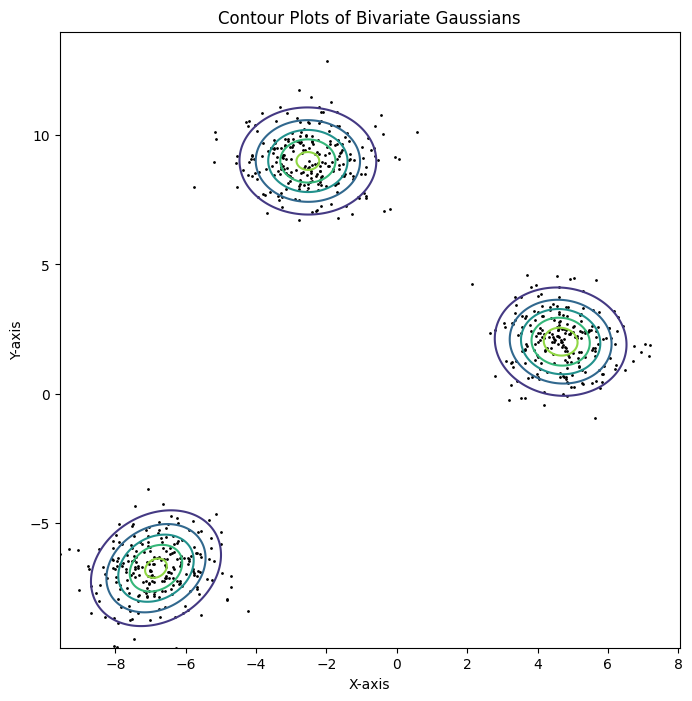

In [4]:
x, y = np.mgrid[min(X_train[:, 0]):max(X_train[:, 0]):.01, min(X_train[:, 1]):max(X_train[:, 1]):.01]
pos = np.dstack((x, y))
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")

# # Plot contours for each mean and covariance
for mean, cov in zip(gmm_classifier.means_, gmm_classifier.covariances_):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=5)


# # Add labels and grid
plt.title("Contour Plots of Bivariate Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()


## Overlaping gaussians

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_81832/3382741830.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


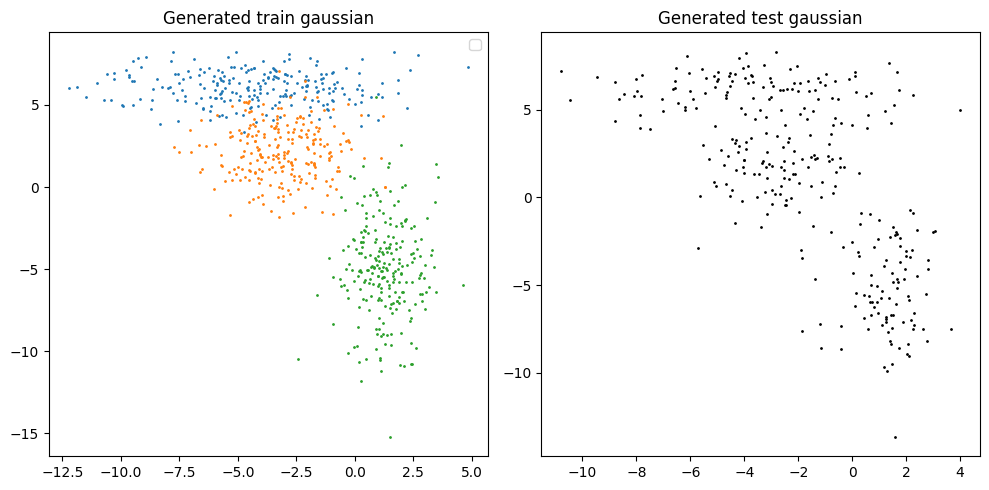

In [5]:
# Generate a multimodal dataset
OMP_NUM_THREADS=1
X, y, c = make_blobs(n_samples=1000, n_features=2, centers=[[-4.0, 6.2],[-3, 2],[ 1.2,-4.9]],
                      cluster_std=[[3.0, 1.], [1.6, 1.8], [1., 3.0]], random_state=69, return_centers=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Generated train gaussian")
for col, cls in zip(["tab:blue", "tab:orange", "tab:green"], range(3)):
    plt.scatter(X_train[y_train==cls, 0], X_train[y_train==cls, 1],  s=1, c=col)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Generated test gaussian")
plt.scatter(X_test[:, 0], X_test[:, 1],  s=1, c="black")

plt.tight_layout()
plt.show()

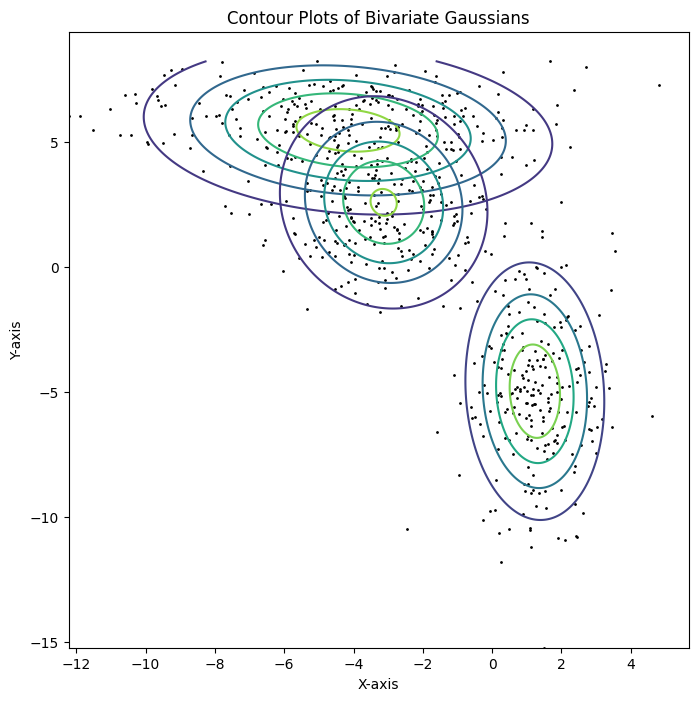

In [6]:
gmm_classifier = GMM(n_components=3, tol=0)
gmm_classifier.fit(X_train)

x, y = np.mgrid[min(X_train[:, 0]):max(X_train[:, 0]):.01, min(X_train[:, 1]):max(X_train[:, 1]):.01]
pos = np.dstack((x, y))
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")

# # Plot contours for each mean and covariance
for mean, cov in zip(gmm_classifier.means_, gmm_classifier.covariances_):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=5)


# # Add labels and grid
plt.title("Contour Plots of Bivariate Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

## BIC GMM

In [7]:
k = np.random.randint(1, 6)
means, stds = generate_means_stds(n_components=k, n_features=2)
X, y = make_blobs(n_samples=1000, n_features=2, centers=means,
                      cluster_std=stds, random_state=69)
bic = BIC_GMM(max_components=8, tol=0)
gmm, k_opt, _ = bic.fit(X)

print(f"Data generated with {k} gaussians\nBIC optimal k: {k_opt}")

Data generated with 4 gaussians
BIC optimal k: 3


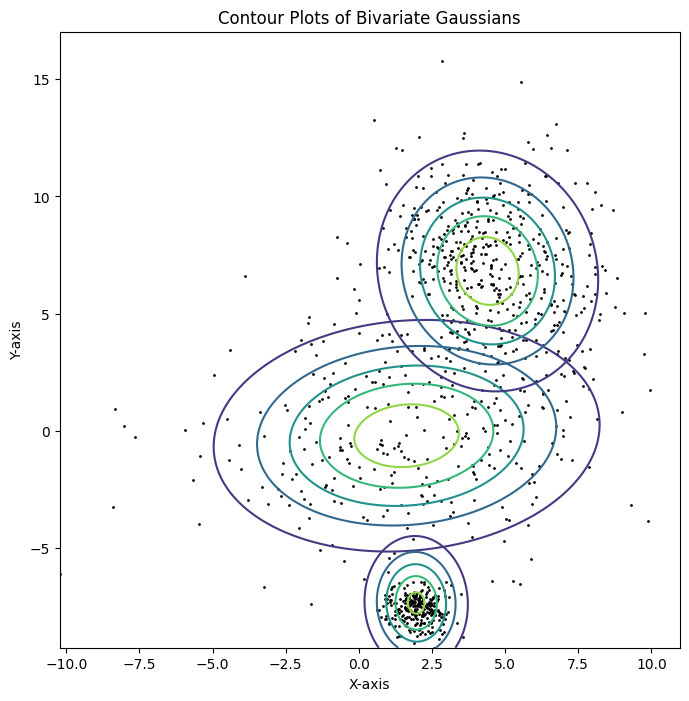

In [8]:
x, y = np.mgrid[min(X[:, 0]):max(X[:, 0]):.01, min(X[:, 1]):max(X[:, 1]):.01]
pos = np.dstack((x, y))
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=1, c="black")

# # Plot contours for each mean and covariance
for mean, cov in zip(gmm.means_, gmm.covariances_):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=5)


# # Add labels and grid
plt.title("Contour Plots of Bivariate Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

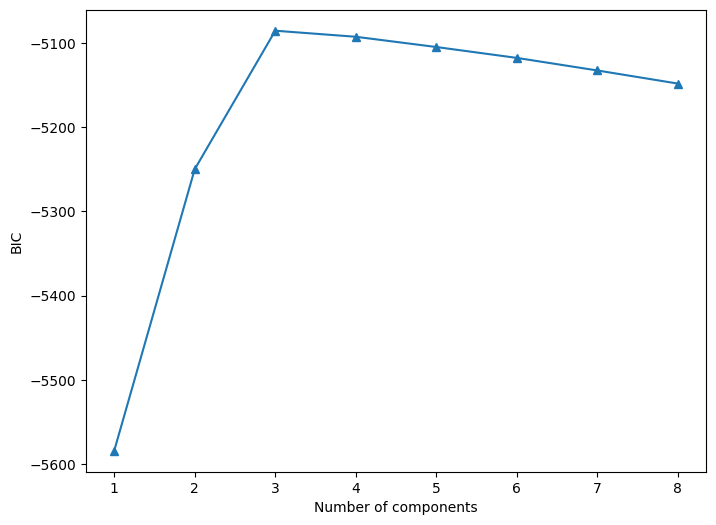

In [9]:
bic.plot_BICs()

# Initialization experiments

## k-means

In [10]:
from typing import Type
gmm_acc = []
gmm_k_acc = []
gmm_m_dist = []
gmm_k_m_dist = []

def calibrate(gmm_model:Type[GMM], X_train, y_train) -> dict:
    cls2gmmcls = {}
    for cls in range(gmm_model.n_components):
        cls_preds = gmm_model.predict(X_train[y_train==cls,:])
        gmm_cls = max(set(cls_preds), key=list(cls_preds).count)
        cls2gmmcls[cls] = int(gmm_cls)
    return cls2gmmcls

def compute_metrics(gmm_model:Type[GMM], X, y, means):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    gmm_model.fit(X_train)
    y_pred = gmm_model.predict(X_test)
    cls2gmmcls = calibrate(gmm_model, X_train, y_train)
    convert_y = np.vectorize(lambda x: cls2gmmcls[x])
    means_dists = [np.linalg.norm(m - gmm_model.means_[cls2gmmcls[i]]) for i, m in enumerate(means)]

    return np.sum(y_pred == convert_y(y_test))/len(y_test), np.mean(means_dists)
    
for _ in range(100):
    means, stds = generate_means_stds(n_components=3, n_features=2)
    X, y = make_blobs(n_samples=1000, n_features=2, centers=means,
                      cluster_std=stds, random_state=69)

    gmm = GMM(n_components=3, tol=0)
    gmm_k = GMM(n_components=3, tol=0, km_init=True)
    
    gmm_metrics = compute_metrics(gmm, X, y, means)
    gmm_k_metrics = compute_metrics(gmm_k, X, y, means)

    gmm_acc.append(gmm_metrics[0])
    gmm_k_acc.append(gmm_k_metrics[0])

    gmm_m_dist.append(gmm_metrics[1])
    gmm_k_m_dist.append(gmm_k_metrics[1])

print(np.mean(gmm_acc), np.mean(gmm_k_acc))
print(np.mean(gmm_m_dist), np.mean(gmm_k_m_dist))

0.9411999999999999 0.9364666666666668
0.7844887051905144 0.49051936382524525
